# Tests! (does my code work?)

## Test construtors in POMDP

In [12]:
using Plots
using Distributions
using Statistics
theme(:solarized)

In [13]:
include("POMDPs.jl")

Main.POMDPs

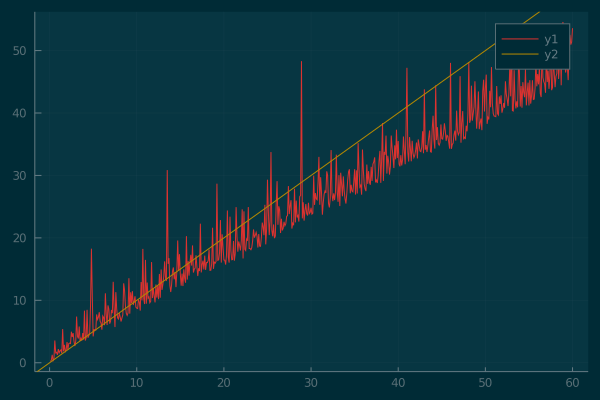

In [14]:
include("Examples.jl")
function T!(x,f)
    Examples.partially_observed_fishery_T!(x,f,Examples.partiallyObservedFishery_pars)
end
R = (x,f) -> Examples.partially_observed_fishery_R!(x,f,Examples.partiallyObservedFishery_pars)
G = (y,x,f) -> Examples.partially_observed_fishery_G(x,y,f,Examples.partiallyObservedFishery_pars)
G_sim = (x,f) -> Examples.partially_observed_fishery_G_sim(x,f,Examples.partiallyObservedFishery_pars)
delta = 0.93
partiallyObservableFishery = POMDPs.init(T!, R, G_sim, G, delta,1, [[1.0]])

x = log.(0.1:0.1:60)
x_copy = log.(0.1:0.1:60)
y = broadcast(x -> partiallyObservableFishery.T!([x], [0.0])[1] ,x)
Plots.plot(exp.(x_copy),exp.(y) )
Plots.abline!(1,0)

# Test `ParticleFilters.jl`
To start use base methods for patially observed systems

In [15]:
include("ParticleFilters.jl")

Main.ParticleFilters

## Initalize a particle filter object

In [16]:

PF = ParticleFilters.init(500,1) # generate particle filter object
prior = Distributions.Normal(3.5,0.5) # set prior distribution
broadcast(i -> PF.samples[i] .= rand(prior,1)[1], 1:PF.N) # sample from prior
print(" ")

Initalizing a standard particle filter 

# Generate a time series of observaitons 

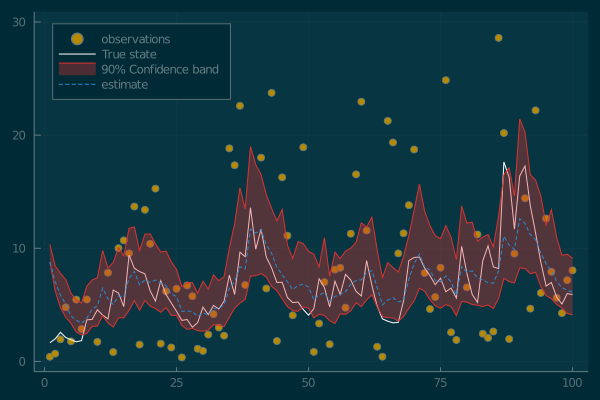

In [17]:
x = [0.5]
t_ = 100
yt = broadcast(i -> zeros(2),1:t_)
xt = zeros(t_)
for t in 1:t_
    xt[t] = x[1]
    yt[t] .= partiallyObservableFishery.G_sim(x,[0.1])
    partiallyObservableFishery.T!(x, [0.1])
end 
# plot observations and true abundnaces 
p1 = Plots.scatter(broadcast(i -> exp(yt[i][1]),1:t_), color = 2, ylim = [0,30], label = "observations")
p1 = Plots.plot!(p1, exp.(xt), color = "white", label = "True state")

x_hat, x_lower, x_upper = zeros(t_), zeros(t_), zeros(t_)
for t in 1:t_
    ParticleFilters.bayes_update!(PF,partiallyObservableFishery.G,yt[t],[0.1])
    ParticleFilters.resample!(PF)
    x_hat[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
    x_lower[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.05)
    x_upper[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.95)
    ParticleFilters.time_update!(PF,partiallyObservableFishery.T!,[0.1])
end 


p1 = Plots.plot!(p1,exp.(x_lower), fillrange = exp.(x_upper), 
    fillalpha = 0.35,  c = 1,
    label = "90% Confidence band", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper), c=1, label = "")
p1 = Plots.plot!(p1, exp.(x_hat), c = 3, linestyle =:dash, label = "estimate")
p1

# Test unscented Kalman Filters

## Initailize `POMDP_KalmanFilter`

In [18]:
# load KalmandFilters.jl and Examples.jl
using KalmanFilters
include("Examples.jl")
include("POMDPs.jl")
# initianize POMDP object
T_! = (x,f) -> Examples.unknown_growth_rate_T!(x,f,(0.2,0.1))
T_ = (x,f) -> Examples.unknown_growth_rate_T(x,f,(0.2,0.1))
R = (x,f) -> sum(x)
Sigma_N = Examples.Sigma_N
H = (x,a) -> Examples.H * x
Sigma_O = reshape(Examples.Sigma_O,1,1)
delta = 0.95
unknownGrowthRate = POMDPs.init(T_!,T_,R,H,Sigma_N,Sigma_O,delta, 1)
print(" ")

## Comapre Particle filter and Kalman filter resutls

Initalizing a standard particle filter 

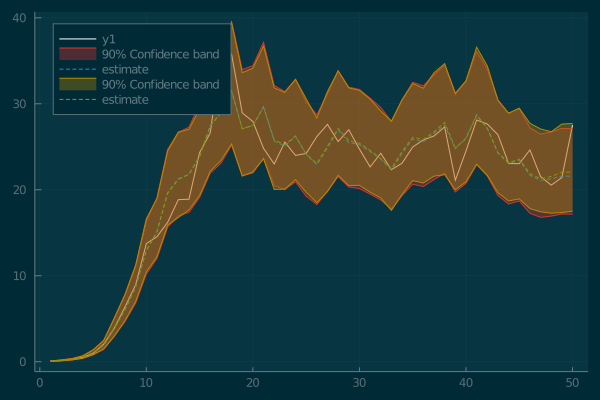

In [19]:

#### generate time series ####
N_ = 50
yt = zeros(N_)
xt = zeros(N_)
x = [-3.5,1.5]
for t in 1:N_
    x = unknownGrowthRate.T_sim!(x,[0.1])
    xt[t] = x[1]
    yt[t] = unknownGrowthRate.G_sim(x,[0.1])[1]
end 
#p1 = Plots.scatter(exp.(yt), c=1)
p1 = Plots.plot(exp.(xt), color = "white")
p1


#### initalize filters ####
# prior distribution 
x0, P0 = [-3.5,1.5],[1.0 0.0; 0.0 0.0025]

# init particle filter
PF = ParticleFilters.init(5000,2) # generate particle filter object
prior = Distributions.MvNormal(x0,P0) # set prior distribution
broadcast(i -> PF.samples[i] .= reshape(rand(prior,1),2), 1:PF.N) # sample from prior

# step 1 to init KalmanFilter object
uKF = KalmanFilters.time_update(x0,P0,
                    x ->unknownGrowthRate.T(x,[0.1]),  unknownGrowthRate.Sigma_N)

uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),yt[1],
                    x ->  unknownGrowthRate.H(x,[0.1]),unknownGrowthRate.Sigma_O)

# update Particle Filter
ParticleFilters.time_update!(PF,unknownGrowthRate.T_sim!,[0.1])
ParticleFilters.bayes_update!(PF,unknownGrowthRate.G,yt[1],[0.1])
ParticleFilters.resample!(PF)
print(" ")


x = get_state(uKF)
P = get_covariance(uKF)

### accumulators ###

# kalman filter
x_hat = zeros(N_)
a_hat = zeros(N_)
x_lower, x_upper = zeros(N_),zeros(N_)
a_lower, a_upper = zeros(N_),zeros(N_)

x_hat[1] = x[1]
a_hat[1] = x[2]

x_lower[1], x_upper[1] = x[1] - 2*sqrt(P[1,1]), x[1] + 2*sqrt(P[1,1])
a_lower[1], a_upper[1] = x[2] - 2*sqrt(P[2,2]), x[2] + 2*sqrt(P[2,2])

# particle filter
x_hat_pf = zeros(N_)
a_hat_pf = zeros(N_)
x_lower_pf, x_upper_pf = zeros(N_),zeros(N_)
a_lower_pf, a_upper_pf = zeros(N_),zeros(N_)

x_hat_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
a_hat_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.5)

x_lower_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.025)
x_upper_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.975)
a_lower_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.025)
a_upper_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.975)

#### iterate ove time series ####
for t in 2:N_
    # update Kalman Filter
    uKF = KalmanFilters.time_update(get_state(uKF),get_covariance(uKF),
                        x ->unknownGrowthRate.T(x,[0.1]),  unknownGrowthRate.Sigma_N)
    
    uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),yt[t],
                           x ->  unknownGrowthRate.H(x,[0.1]),unknownGrowthRate.Sigma_O)
    
    
    # update Particle Filter
    ParticleFilters.time_update!(PF,unknownGrowthRate.T_sim!,[0.1])
    ParticleFilters.bayes_update!(PF,unknownGrowthRate.G,yt[t],[0.1])
    ParticleFilters.resample!(PF)
    
    
    
    x = get_state(uKF)
    P = get_covariance(uKF)
    x_hat[t] = x[1]
    a_hat[t] = x[2]

    x_lower[t], x_upper[t] = x[1] - 2*sqrt(P[1,1]), x[1] + 2*sqrt(P[1,1])
    a_lower[t], a_upper[t] = x[2] - 2*sqrt(P[2,2]), x[2] + 2*sqrt(P[2,2])
    
    # particel filter data     
    x_hat_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
    x_lower_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.025)
    x_upper_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.975)
    
    
    a_hat_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.5)
    a_lower_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.025)
    a_upper_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.975)
end 


p1 = Plots.plot!(p1,exp.(x_lower), fillrange = exp.(x_upper), 
    fillalpha = 0.35,  c = 1,
    label = "90% Confidence band", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper), c=1, label = "")
p1 = Plots.plot!(p1, exp.(x_hat), c = 3, linestyle =:dash, label = "estimate")

p1 = Plots.plot!(p1,exp.(x_lower_pf), fillrange = exp.(x_upper_pf), 
    fillalpha = 0.35,  c = 2,
    label = "90% Confidence band", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper_pf), c=2, label = "")
p1 = Plots.plot!(p1, exp.(x_hat_pf), c = 4, linestyle =:dash, label = "estimate")


p1

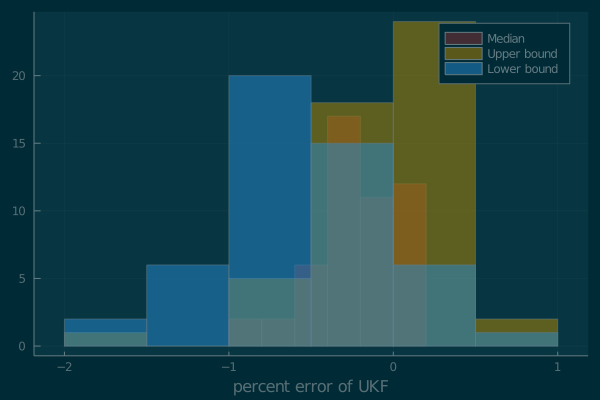

In [20]:
Plots.histogram(100 *(x_hat .- x_hat_pf)./mean(x_hat_pf),
    xlab = "percent error of UKF", label = "Median", alpha = 0.3)
Plots.histogram!(100 *(x_upper .- x_upper_pf)./mean(x_upper_pf), 
    label = "Upper bound", alpha = 0.5)
Plots.histogram!(100 *(x_lower .- x_lower_pf)./mean(x_lower_pf), 
    label = "Lower bound", alpha = 0.5)

# Test `MvGaussHermite`
## to solveintegrals for bellman opperator

In [438]:
using FastGaussQuadrature
using LinearAlgebra
using IterTools
include("MvGaussHermite.jl")

Main.MvGaussHermite

# Test 2 dimensional GH quadrature 

In [439]:
Cov = [0.25 -0.2;-0.2 0.3] .* 2.0
m = 4
Quad = MvGaussHermite.init(m, [0,0.0],Cov)

Main.MvGaussHermite.quadrature([0.01605018360933761, 0.04668426114935483, 0.04668426114935483, 0.01605018360933761, 0.04668426114935483, 0.13578786960376119, 0.13578786960376119, 0.04668426114935483, 0.04668426114935483, 0.13578786960376119, 0.13578786960376119, 0.04668426114935483, 0.01605018360933761, 0.04668426114935483, 0.04668426114935483, 0.01605018360933761], AbstractArray{Float64,1}[[1.5082680645200224, -1.7085392442759781], [1.2225977965107804, -0.9238325769074363], [0.9563954851739278, -0.19260237213097525], [0.6707252171646858, 0.5921042952375665], [0.7650540346530617, -1.327744074078104], [0.47938376664381965, -0.5430374067095622], [0.21318145530696717, 0.18819279806689887], [-0.07248881270227481, 0.9728994654354406], [0.07248881270227481, -0.9728994654354406], [-0.21318145530696717, -0.18819279806689887], [-0.47938376664381965, 0.5430374067095622], [-0.7650540346530617, 1.327744074078104], [-0.6707252171646858, -0.5921042952375665], [-0.9563954851739278, 0.1926023721309752

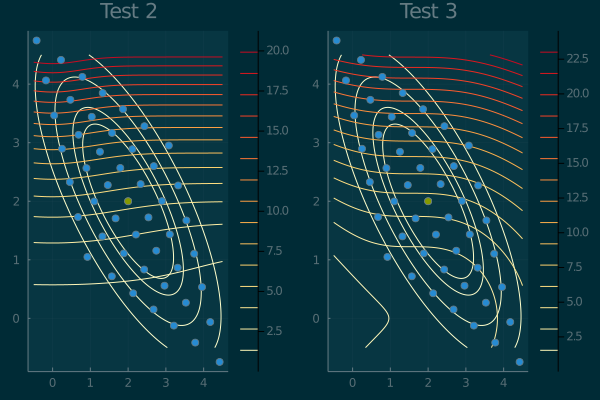

┌ Warning: Multiple series with different levels share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /Users/johnbuckner/.julia/packages/Plots/SjqWU/src/backends/gr.jl:498
┌ Warning: Multiple series with different levels share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /Users/johnbuckner/.julia/packages/Plots/SjqWU/src/backends/gr.jl:498


In [440]:

# prune 
theta = 0.00001 / m^2
# covariance matrix and transform
y_hat = [2.0,2.0]
Cov = [0.25 -0.2;-0.2 0.3] .* 2.0
m = 7
Quad = MvGaussHermite.init(m,y_hat , Cov)


nodes_x = broadcast(i -> Quad.nodes[i][1], 1:Quad.n)
nodes_y = broadcast(i -> Quad.nodes[i][2], 1:Quad.n)

xs = -0.5:0.025:4.5
ys = -0.5:0.025:4.5
dsn = Distributions.MvNormal(y_hat, Cov)
pdf_ = (x,y) -> pdf(dsn, [x,y])
function ftest1(x)
    return x[1]+x[2] + x[1]*x[2] + x[1]^2
end 

function ftest2(x)
    return sum(sin(4*x[1]*x[2])*cos(x[2])+x[1])
end 

function ftest2(x)
    return exp(-0.05*(x[1]*x[2])^2)
end 

function ftest3(x)
    return sum(x[1]+x[2]^2 + cos(3*x[2]*x[1]))
end 
        
        
function ftest2(x,y)
    x = [x,y]
    return exp(-0.05*(x[1]*x[2])^2) + x[2]^2
end 
            
function ftest3(x,y)
    x = [x,y]
    return sum(x[1]+x[2]^2 + cos(x[1]))
end 
p1 = Plots.contour(xs, ys, pdf_, fill=false, levels = [0.1,0.01,0.05,0.001])
Plots.contour!(xs, ys, ftest2, fill=false)

Plots.scatter!(nodes_x,nodes_y)
Plots.scatter!([y_hat[1]], [y_hat[2]], legend = false, title = "Test 2")

p2 = Plots.contour(xs, ys, pdf_, fill=false, levels = [0.1,0.01,0.05,0.001])
Plots.contour!(xs, ys, ftest3, fill=false)

Plots.scatter!(nodes_x,nodes_y)
Plots.scatter!([y_hat[1]], [y_hat[2]], legend = false, title = "Test 3")
plot(p1,p2)

## Compare computed expctations for three test functions
### using `MvGaussHermite.jl` and Montecarlo integration

In [441]:
### compare montecarlo and Gauss Hermite 
# function 1
N_mc = 100000
mcf1 = sum(ftest1.(broadcast(i -> rand(dsn, 1), 1:N_mc)))/N_mc
ghf1 = MvGaussHermite.expected_value(ftest1, Quad)
print("test one Montecarlo: " , mcf1, "\n")
print("test one Gauss Hermite: " , ghf1, "\n")
print("percent diference: " , round((mcf1-ghf1)/mcf1*100,digits = 2), "% \n")
print("\n")
# function 2
mcf2 = sum(ftest2.(broadcast(i -> rand(dsn, 1), 1:N_mc)))/N_mc
ghf2 = MvGaussHermite.expected_value(ftest2, Quad)
print("test two Montecarlo: " , mcf2, "\n")
print("test two Gauss Hermite: " , ghf2, "\n")
print("percent diference: " ,round( (mcf2-ghf2)/mcf2*100, digits = 2), "% \n")
print("\n")
# function 3
mcf3 = sum(ftest3.(broadcast(i -> rand(dsn, 1), 1:N_mc)))/N_mc
ghf3 = MvGaussHermite.expected_value(ftest3, Quad)
print("test three Montecarlo: " , mcf3, "\n")
print("test three Gauss Hermite: " , ghf3, "\n")
print("percent diference: " , round((mcf3-ghf3)/mcf3*100, digits = 2), "% \n")
print("\n")

test one Montecarlo: 12.1011212533143
test one Gauss Hermite: 12.091119958083766
percent diference: 0.08% 

test two Montecarlo: 0.5292491102157957
test two Gauss Hermite: 0.5287788178470653
percent diference: 0.09% 

test three Montecarlo: 6.573807938316632
test three Gauss Hermite: 6.578848571090454
percent diference: -0.08% 



## Test 3d quadrature

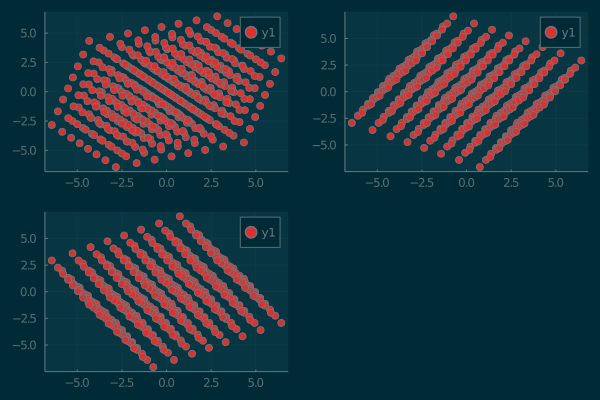

In [442]:
include("MvGaussHermite.jl")
Cov = [2.0 0.5 0.0; 0.5 2.0 0.0; 0.0 0.0 2.0]
y_hat = [0.0, 0.0, 0.0]
m = 8
Quad_3d = MvGaussHermite.init(m, y_hat, Cov)
nodes_x = broadcast(i -> Quad_3d.nodes[i][1], 1:Quad_3d.n)
nodes_y = broadcast(i -> Quad_3d.nodes[i][2]  , 1:Quad_3d.n)
nodes_z = broadcast(i -> Quad_3d.nodes[i][3] , 1:Quad_3d.n)

dsn_3d = Distributions.MvNormal(y_hat, Cov)

p1 = Plots.scatter(nodes_x, nodes_y)
p2 = Plots.scatter(nodes_x, nodes_z)
p3 = Plots.scatter(nodes_y, nodes_z)
plot(p1,p2,p3)

In [444]:
test_f1(x) = x[1]+x[2]+x[3] + x[2]*x[3] +x[2]^2+x[3]^2+x[1]^2
test_f2(x) = x[1]+x[2]+x[3] + sin(2*x[2]*x[3]) + x[1]^2
test_f3(x) = 0.1*x[1]+0.2*x[2]^2+exp(-0.1*x[3]^2) 
Nmc = 1000000
samples = broadcast(i -> rand(dsn_3d, 1), 1:Nmc)
val1_gh = MvGaussHermite.expected_value(test_f1, Quad_3d)
val1_mc = sum(test_f1.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh)/val1_mc*100, digits = 2), "%")
print("\n")

val2_gh = MvGaussHermite.expected_value(test_f2, Quad_3d)
val2_mc = sum(test_f2.(samples))/Nmc 
println("Gauss hermite: ", val2_gh)
println("Montecarlo: ", val2_mc)
println("percent diference: " , round((val2_mc-val2_gh)/val2_mc*100, digits = 2), "%")
print("\n")

val3_gh = MvGaussHermite.expected_value(test_f3, Quad_3d)
val3_mc = sum(test_f3.(samples))/Nmc 
println("Gauss hermite: ", val3_gh)
println("Montecarlo: ", val3_mc)
println("percent diference: " , round((val3_mc-val3_gh)/val3_mc*100, digits = 2), "%")
print("\n")

Gauss hermite: 5.984054326519408
Montecarlo: 6.000814714755947
percent diference: 0.28%

Gauss hermite: 2.0265980561616788
Montecarlo: 2.0013351301613884
percent diference: -1.26%

Gauss hermite: 1.2439913359425414
Montecarlo: 1.2452085272538416
percent diference: 0.1%



## Test 4 dimensions 

In [445]:
include("MvGaussHermite.jl")
Cov = [1.0 0.5 0.0 0.0; 0.5 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
y_hat = [0.0, 0.0, 0.0, 0.0]
m = 8
Quad_4d = MvGaussHermite.init(m, y_hat, Cov)
nodes_x = broadcast(i -> Quad_4d.nodes[i][1], 1:Quad_4d.n)
nodes_y = broadcast(i -> Quad_4d.nodes[i][2], 1:Quad_4d.n)
nodes_z = broadcast(i -> Quad_4d.nodes[i][3], 1:Quad_4d.n)
nodes_w = broadcast(i -> Quad_4d.nodes[i][4], 1:Quad_4d.n)

dsn_4d = Distributions.MvNormal(y_hat, Cov)

p1 = Plots.scatter(nodes_x, nodes_y)
p2 = Plots.scatter(nodes_x, nodes_z)
p3 = Plots.scatter(nodes_x, nodes_w)
p4 = Plots.scatter(nodes_y, nodes_z)
p5 = Plots.scatter(nodes_y, nodes_w)
p6 = Plots.scatter(nodes_z, nodes_w)
plot(p1,p2,p3,p4,p5,p6)

In [446]:
test_f1(x) = x[1]+x[2]+x[3] + x[2]*x[3]*x[4] +x[1]^2+x[2]^2+x[3]^2+x[4]^2
test_f2(x) = x[1]+x[2]+x[3] + sin(2*x[2]*x[3]*x[4])
test_f3(x) = exp(-0.1*x[3]+0.1*x[4]) + cos(x[2]*x[1]) + x[4]*x[3]^2+x[2]^2
Nmc = 1000000
samples = broadcast(i -> rand(dsn_4d, 1), 1:Nmc)
val1_gh = MvGaussHermite.expected_value(test_f1, Quad_4d)
val1_mc = sum(test_f1.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh), digits = 2))
print("\n")

val1_gh = MvGaussHermite.expected_value(test_f2, Quad_4d)
val1_mc = sum(test_f2.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh), digits = 2))
print("\n")

val1_gh = MvGaussHermite.expected_value(test_f3, Quad_4d)
val1_mc = sum(test_f3.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh), digits = 2))
print("\n")

Gauss hermite: 3.9889193282634325
Montecarlo: 3.997467888810088
percent diference: 0.01

Gauss hermite: 1.1102230246251565e-16
Montecarlo: -0.0031616135353141153
percent diference: -0.0

Gauss hermite: 2.68756188460671
Montecarlo: 2.689714880334072
percent diference: 0.0



# Test error propogation through observaton model 

In [436]:
include("BellmanOpperators.jl")
include("MvGaussHermite.jl")
BellmanOpperators.propogate_observation_model([1.0,1.0],[1.0 0.5;0.5 1.0], [1.0 0.1;0.1 1.0])

([1.1, 1.1], [1.11 0.705; 0.705 1.11])

# Test quadrature propogation with linear function
m = 6

In [437]:
m = 6
x_hat = [1.0,1.0]
x_cov = [1.0 0.5; 0.5 1.0]
H_mat = [2.0 0.25;0.25 1.0]
H = x -> H_mat *x
Quad = MvGaussHermite.init_mutable(m, [1.0 0.0;0.0 1.0])
mu, Cov = BellmanOpperators.propogate_observation_model(x_hat, x_cov, H, Quad)
println((round.(mu,digits = 4),round.(Cov,digits = 4)))
println(BellmanOpperators.propogate_observation_model(x_hat, x_cov, H_mat))

LoadError: [91mMethodError: no method matching propogate_observation_model(::Array{Float64,1}, ::Array{Float64,2}, ::var"#1019#1020", ::Main.MvGaussHermite.mutableQuadrature)[39m
[91m[0mClosest candidates are:[39m
[91m[0m  propogate_observation_model(::AbstractArray{Float64,1}, ::AbstractArray{Float64,2}, ::Function, [91m::Main.BellmanOpperators.MvGaussHermite.mutableQuadrature[39m) at /Users/johnbuckner/github/ADP_julia/BellmanOpperators.jl:40[39m
[91m[0m  propogate_observation_model(::AbstractArray{Float64,1}, ::AbstractArray{Float64,2}, [91m::AbstractArray{Float64,2}[39m) at /Users/johnbuckner/github/ADP_julia/BellmanOpperators.jl:49[39m

In [407]:
m = 10
x_hat = [1.0,1.0]
x_cov = [1.0 0.5; 0.5 1.0]
H_mat = [2.0 0.25;0.25 1.0]
H = x -> H_mat *x
Quad = MvGaussHermite.init_mutable(m, [1.0 0.0;0.0 1.0])
mu, Cov = BellmanOpperators.propogate_observation_model(x_hat, x_cov, H, Quad)
println((round.(mu,digits = 4),round.(Cov,digits = 4)))
println(BellmanOpperators.propogate_observation_model(x_hat, x_cov, H_mat))

([2.2499, 1.25], [4.5609 1.7806; 1.7806 1.312])
([2.25, 1.25], [4.5625 1.78125; 1.78125 1.3125])


## Test against non-linear function

In [614]:
f(x) = sin(1.25*x)+0.1*x^2
H = x -> [f(([1.0 1.0] * x)[1])]
mu, Cov = BellmanOpperators.propogate_observation_model(x_hat, x_cov, H, Quad)
println((round.(mu,digits = 4),round.(Cov,digits = 4)))

LoadError: [91mMethodError: no method matching propogate_observation_model(::Array{Float64,1}, ::Array{Float64,2}, ::var"#1057#1058", ::Main.MvGaussHermite.quadrature)[39m
[91m[0mClosest candidates are:[39m
[91m[0m  propogate_observation_model(::AbstractArray{Float64,1}, ::AbstractArray{Float64,2}, ::Function, [91m::Main.BellmanOpperators.MvGaussHermite.mutableQuadrature[39m) at /Users/johnbuckner/github/ADP_julia/BellmanOpperators.jl:40[39m
[91m[0m  propogate_observation_model(::AbstractArray{Float64,1}, ::AbstractArray{Float64,2}, [91m::AbstractArray{Float64,2}[39m) at /Users/johnbuckner/github/ADP_julia/BellmanOpperators.jl:49[39m

## Test Value functions 

In [615]:
include("ValueFunctions.jl")

Main.ValueFunctions

In [627]:
a = [-2.0,-2.0]
b = [2.0,2.0]
m = 20
p = ValueFunctions.init_interpolation(a,b,m)

Main.ValueFunctions.chebyshevInterpolation(2, [-2.0, -2.0], [2.0, 2.0], 20, [0.012330665067488145 0.012330665067488145; 0.11052031840929377 0.11052031840929377; … ; 7.889479681590706 7.889479681590706; 7.987669334932512 7.987669334932512], [(0.012330665067488145, 0.012330665067488145) (0.012330665067488145, 0.11052031840929377) … (0.012330665067488145, 7.889479681590706) (0.012330665067488145, 7.987669334932512); (0.11052031840929377, 0.012330665067488145) (0.11052031840929377, 0.11052031840929377) … (0.11052031840929377, 7.889479681590706) (0.11052031840929377, 7.987669334932512); … ; (7.889479681590706, 0.012330665067488145) (7.889479681590706, 0.11052031840929377) … (7.889479681590706, 7.889479681590706) (7.889479681590706, 7.987669334932512); (7.987669334932512, 0.012330665067488145) (7.987669334932512, 0.11052031840929377) … (7.987669334932512, 7.889479681590706) (7.987669334932512, 7.987669334932512)], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.

In [628]:
g(x) = cos(x[1]^2+x[2]^2) 
new_values = g.(p.grid)
ValueFunctions.update_interpolation!(p, new_values)


231-element Array{Float64,1}:
  0.20230124792035653
 -0.06536399140284317
  0.07401182901843116
 -0.20315068046296766
  0.07543092771946933
  0.13134229941888986
  0.0015156923971463279
  0.13110785626732896
  0.08719977258948315
  0.06543311784160598
  0.03606659138894063
 -0.11682204593016271
  0.0001852859270859039
  ⋮
 -0.17137014939167106
 -0.006405335875875931
 -0.089484054930357
  0.051977414560703164
 -0.045150745851616166
  0.06670954134066795
 -0.09010144913069812
  0.030824309314815144
 -0.033885116009950006
  0.09706829924676257
  0.03952210726763123
 -1.2947053755463498e-15

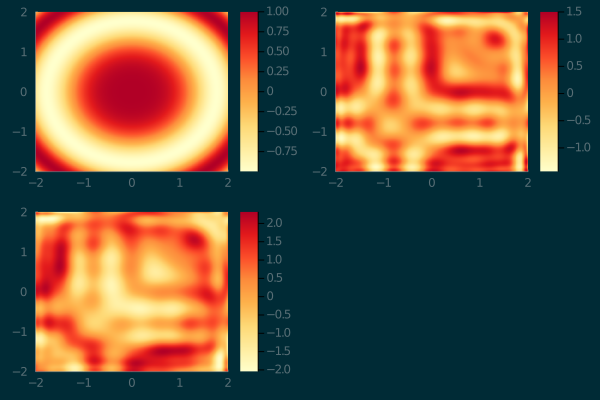

In [629]:
# define grid for plots
x = a[1]:0.01:b[1]
y = a[2]:0.01:b[2]
xy = collect(Iterators.product(x,y))

# calculate true values
v_true = g.(xy)


# reshape xy from an array to a vector and call  evaluate_interpolation
vec_xy = reshape(xy,length(xy))
v_itp = p(vec_xy)

# convert back to grid for plot
v_itp_grid = reshape(v_itp, length(x), length(y))

# make plots
p1 = Plots.heatmap(y,x,v_true)
p2 = Plots.heatmap(y,x,v_itp_grid)
#p3 = Plots.heatmap(y,x,v_itp_grid .- v_true)
plot(p1,p2)#,p3,layout = 3)


In [609]:
collect(grid)

161×161 Array{Tuple{Float64,Float64},2}:
 (-2.0, -2.0)    (-2.0, -1.975)    …  (-2.0, 1.975)    (-2.0, 2.0)
 (-1.975, -2.0)  (-1.975, -1.975)     (-1.975, 1.975)  (-1.975, 2.0)
 (-1.95, -2.0)   (-1.95, -1.975)      (-1.95, 1.975)   (-1.95, 2.0)
 (-1.925, -2.0)  (-1.925, -1.975)     (-1.925, 1.975)  (-1.925, 2.0)
 (-1.9, -2.0)    (-1.9, -1.975)       (-1.9, 1.975)    (-1.9, 2.0)
 (-1.875, -2.0)  (-1.875, -1.975)  …  (-1.875, 1.975)  (-1.875, 2.0)
 (-1.85, -2.0)   (-1.85, -1.975)      (-1.85, 1.975)   (-1.85, 2.0)
 (-1.825, -2.0)  (-1.825, -1.975)     (-1.825, 1.975)  (-1.825, 2.0)
 (-1.8, -2.0)    (-1.8, -1.975)       (-1.8, 1.975)    (-1.8, 2.0)
 (-1.775, -2.0)  (-1.775, -1.975)     (-1.775, 1.975)  (-1.775, 2.0)
 (-1.75, -2.0)   (-1.75, -1.975)   …  (-1.75, 1.975)   (-1.75, 2.0)
 (-1.725, -2.0)  (-1.725, -1.975)     (-1.725, 1.975)  (-1.725, 2.0)
 (-1.7, -2.0)    (-1.7, -1.975)       (-1.7, 1.975)    (-1.7, 2.0)
 ⋮                                 ⋱                   ⋮
 (1.725, -2.0)  

In [511]:
p.grid

2×2 Array{Tuple{Float64,Float64},2}:
 (0.0489435, 0.412215)  (0.0489435, 0.412215)
 (0.0489435, 0.412215)  (0.0489435, 0.412215)

In [514]:
p.nodes[:,1]

5-element Array{Float64,1}:
 0.04894348370484647
 0.41221474770752686
 0.9999999999999999
 1.587785252292473
 1.9510565162951536